# Feature engineering for Exchange Data Module

This notebook generates features for the exchange data (see section ?? of the paper).

The **input** files for this notebook are:

- master list: should be located in the root folder;
- Exchange data for an asset (BTCUSDT in our case): should be located in the root folder. We splitted the data by the timestamps in master list, i.e. for each of the timestamp we retrieved the data for exchanges 15m before the closing time of the timestamp.

The **output** files for this notebook are:

- features data frame: will be placed in the current folder.

<img align="left" width="678" height="344" src="../assets/exchange_module.png">

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import sys
sys.path.append('..')
import warnings
warnings.filterwarnings("ignore")

from feature_engineering import *
from utils import *

In [3]:
master_list = pd.read_csv('../master_list_v3_DBI.csv')
master_list['close_time'] = pd.to_datetime(master_list['close_time'])
master_list['target'].value_counts()

 0    1645
 1     568
-1     386
Name: target, dtype: int64

# Read the data

In [4]:
# GMT+4 time zone
agg_trades_collection = []
for i in trange(len(master_list)):
    data_dbi = pd.read_parquet(f'trades_data_DBI/{i}.parquet')
    agg_trades_collection.append(data_dbi)

100%|██████████████████████████████████████| 2599/2599 [00:20<00:00, 124.97it/s]


### Plot sample data

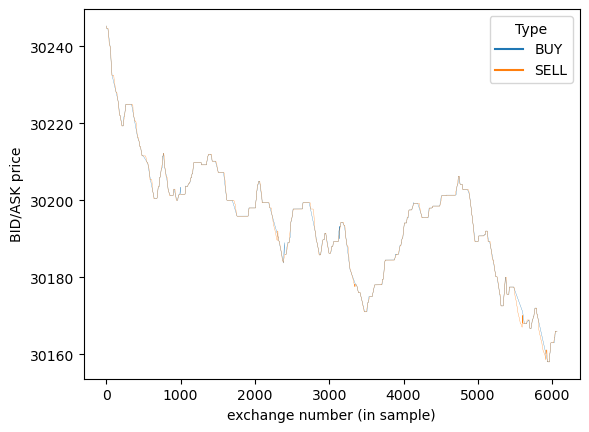

In [5]:
data = deepcopy(agg_trades_collection[-402])

fig, ax = plt.subplots(1, 1)
sns.lineplot(data=data,
             x=data.index,
             y='Price',
             hue='Type',
         color='black', 
         linewidth=0.2)

ax.set_xlabel('exchange number (in sample)')
ax.set_ylabel('BID/ASK price')
plt.show()

### Calculate basic stats

In [6]:
# Basic stats for the returns data
data['returns'] = data['Price'].pct_change()
data['dolAmount'] = data['Price'] * data['Quantity']
print('Kurtosis', data['returns'].kurtosis())
print('Skewness', data['returns'].skew())

Kurtosis 75.81142
Skewness 0.67773515


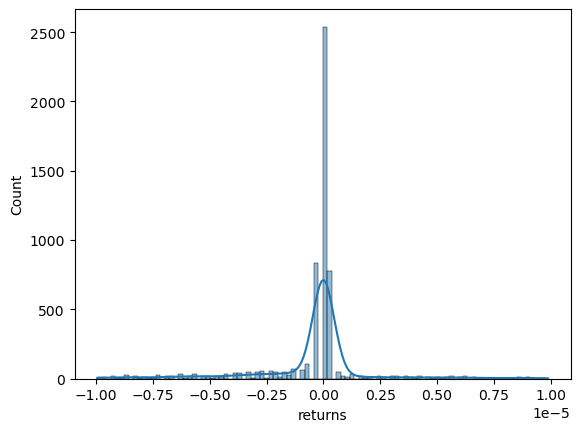

In [7]:
# Plot distribution of returns
sns.histplot(data=data[(data['returns'] < 1e-5) & (data['returns'] > -1e-5)], x='returns', bins=100, kde=True);

### Bin the exchanges by dollar amount

In [8]:
# Bin the data by dollar amount
bins = [0, 10, 100, 500, 1000, 10000, 50000, 1e30]
bins_labels = {1: '0-10$', 2: '10-100$', 3: '100-500$', 4: '500-1k$', 5: '1k-10k$', 6: '10k-50k$', 7: '>50k$'}
labels = [1, 2, 3, 4, 5, 6, 7]

data['bins'] = pd.cut(data['dolAmount'], bins=bins, labels=labels, include_lowest=True, retbins=False)
data['bins_labels'] = data['bins'].map(bins_labels)

# Create aggregated data frame for each bin
bars = pd.DataFrame()
bars['val'] = data.groupby('bins_labels')['dolAmount'].sum()
bars = bars.reset_index()

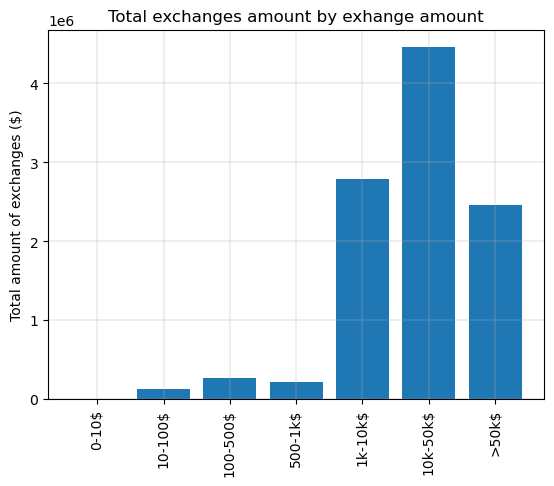

In [9]:
plt.title('Total exchanges amount by exhange amount')
plt.bar(bars['bins_labels'], bars['val'])
plt.grid(True, linewidth=0.3)
plt.xticks(rotation=90)
plt.ylabel('Total amount of exchanges ($)')
plt.show()

# Features

In [10]:
features = feature_engineering_exchange(master_list, agg_trades_collection)
features.to_csv('features.csv', index=False)

100%|███████████████████████████████████████| 2599/2599 [01:20<00:00, 32.36it/s]


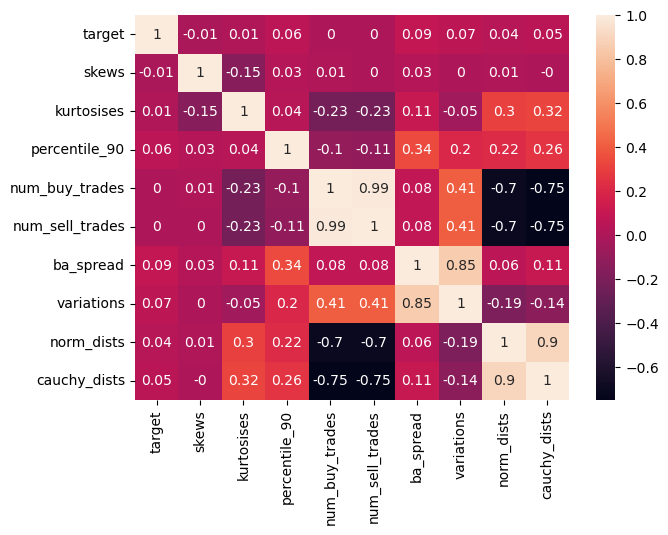

In [11]:
plt.figure(figsize=(7, 5))
sns.heatmap(features.corr(numeric_only=True).round(2), annot=True)
plt.show()

# ROC-AUC

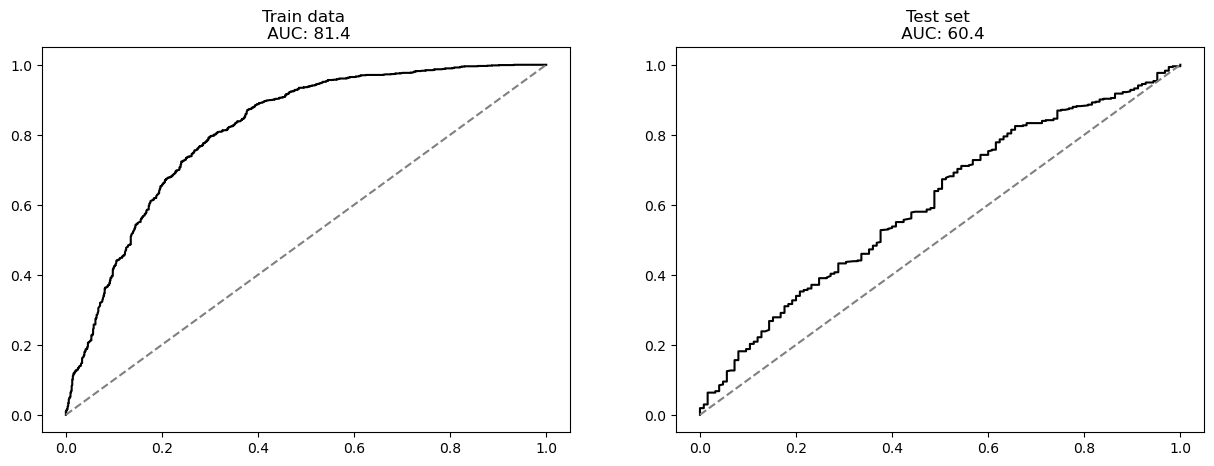

In [12]:
plot_roc_auc(features, 'ba_spread')